In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from keras import models
from keras import layers
import statistics
%matplotlib inline


print(tf.__version__)

2.14.0


## Image analysis

Number of images: 1644
Mean: 104.99878345498783
Geometric mean: 91.36642048787509
Median: 81.0
Min: 48
Max: 711
Last non-outlier dimension: 193


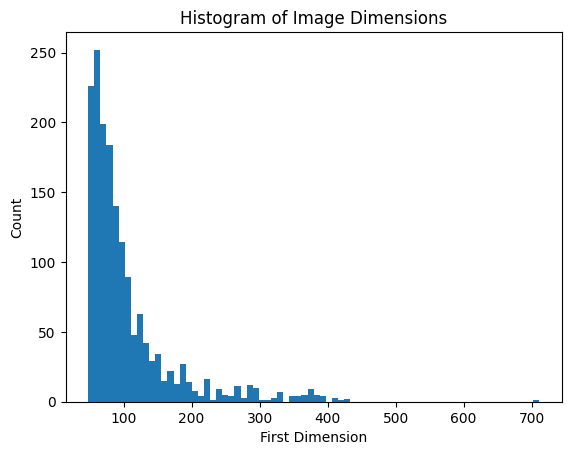

In [2]:
dataset = "../mldataset/cropped"
dirs = [os.path.join(dataset, "Meteors"), os.path.join(dataset, "Artifacts")]
dimensions = []

for i in dirs:
    for j in os.listdir(i):

        img = os.path.join(i, j)

        if "synthesized" in img:

            for synth in os.listdir(img):
                img3 = os.path.join(img, synth)

                img2 = Image.open(img3)
                img_array = np.array(img2)
                dimensions.append(img_array.shape[0])
                img_array = np.expand_dims(img_array, axis=-1)
        else:
            img = Image.open(img)
            img_array = np.array(img)
            dimensions.append(img_array.shape[0])
            img_array = np.expand_dims(img_array, axis=-1)

print("Number of images:", len(dimensions))
print("Mean:", np.mean(dimensions))
print("Geometric mean:", statistics.geometric_mean(dimensions))
print("Median:", np.median(dimensions))
print("Min:", np.min(dimensions))
print("Max:", np.max(dimensions))

q1 = np.percentile(dimensions, 25)
q3 = np.percentile(dimensions, 75)
iqr = q3 - q1
threshold = 1.5 * iqr
dimensions = np.sort(np.array(dimensions))
first_outlier = np.where((dimensions < q1 - threshold) | (dimensions > q3 + threshold))[0]
print("Last non-outlier dimension:", dimensions[first_outlier[0] - 1])


plt.hist(dimensions, bins="auto")

plt.xlabel("First Dimension")
plt.ylabel("Count")
plt.title("Histogram of Image Dimensions")
plt.show()

In [3]:
confirmed_num = 0

confirmed_num += len(os.listdir(dirs[0]))
print("Number of meteor images:", confirmed_num)

rejected_images = []
rejected_num = 0

for filename in os.listdir(dirs[1]):
    if "synthesized" in filename:
        rejected_images += [
            os.path.join(dirs[1], filename, synth)
            for synth in os.listdir(os.path.join(dirs[1], filename))
        ]
    else:
        rejected_images.append(os.path.join(dirs[1], filename))

rejected_num = len(rejected_images)
print("Number of artifact images:", rejected_num)

Number of meteor images: 822
Number of artifact images: 822


## Class balancing using image augmentation


In [4]:
data_augmentation = tf.keras.Sequential(
    [
        # TODO: Modify data augmentation layers
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.2),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomZoom(0.2, 0.2),
    ]
)

# balance classes by using data augmentation
while rejected_num < confirmed_num:
    random_image = tf.random.shuffle(rejected_images)[0]
    random_image_path = random_image.numpy().decode("utf-8")
    if "synthesized" in random_image_path:
        continue
    img = Image.open(random_image_path)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)

    img_array = data_augmentation(img_array)

    augmented_img = Image.fromarray(np.squeeze(img_array).astype(np.uint8))
    os.makedirs(os.path.join(dirs[1], "synthesized"), exist_ok=True)
    # Save the image
    base_filename = os.path.basename(random_image_path)[:-4] + "_augmented"
    full_path = os.path.join(dirs[1], "synthesized", base_filename + ".png")
    i = 1

    # Loop until we find a filename that does not already exist
    while os.path.exists(full_path):
        # If a file with the same name already exists, append the counter to the filename
        full_path = os.path.join(
            dirs[1], "synthesized", base_filename + "_" + str(i) + ".png"
        )
        # Increment the counter
        i += 1
    augmented_img.save(full_path)
    rejected_num += 1
print("Classes balanced.")
print("Number of meteor images:", confirmed_num)
print("Number of artifact images:", rejected_num)

Classes balanced.
Number of meteor images: 822
Number of artifact images: 822


## Dataset creation


In [5]:
IMG_SIZE = int(np.median(dimensions))  # seems about right
# IMG_SIZE = first_outlier
BATCH_SIZE = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset,
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="both",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
)

class_names = train_ds.class_names

Found 1644 files belonging to 2 classes.
Using 1151 files for training.
Using 493 files for validation.


### Dataset normalization


In [6]:
def standardize_image(image, label):
    """
    Linearly scales each image in image to have mean 0 and variance 1.
    """
    image = rescale(image)
    image = tf.image.per_image_standardization(image)

    return image, label


AUTOTUNE = tf.data.AUTOTUNE

rescale = layers.Rescaling(1.0 / 255)

# standardize each image to have mean 0 and variance 1
train_ds = train_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)

dataset_name="20240412_1"
train_ds.save(f"datasets/{dataset_name}_train")
val_ds.save(f"datasets/{dataset_name}_val")


## Model creation


In [7]:
# model from https://github.com/fiachraf/meteorml/blob/main/keras/training_scripts/CNN_script_20220325_1.py#L133

model = models.Sequential()
model_name= "CNN_20240412_1"
model._name = model_name

# added by me, so that these normalization steps arent done before the model
# model.add(layers.Resizing(IMG_SIZE, IMG_SIZE))
# model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(8, (5, 5), activation="relu"))
model.add(layers.MaxPooling2D((5, 5)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.build((BATCH_SIZE, IMG_SIZE, IMG_SIZE, 1))

model.summary()

json_config = model.to_json()
with open(f'models/{model_name}_config.json', 'w') as json_file:
    json_file.write(json_config)



Model: "CNN_20240412_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 77, 77, 8)           208       
                                                                 
 max_pooling2d (MaxPooling2  (32, 15, 15, 8)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (32, 1800)                0         
                                                                 
 dense (Dense)               (32, 16)                  28816     
                                                                 
 dense_1 (Dense)             (32, 1)                   17        
                                                                 
Total params: 29041 (113.44 KB)
Trainable params: 29041 (113.44 KB)
Non-trainable params: 0 (0.00 Byte)
______________